# Neural Network 

In [28]:
import pandas as pd
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 

# Import data 

In [29]:
# Load the data into pandas dataframes
X_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/X_train_smote_12-06-2024.csv')
y_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/y_train_smote_12-06-2024.csv')
X_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/X_test_12-06-2024.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/y_test_12-06-2024.csv')

In [30]:
# Drop unnamed columns 
X_train = X_train.drop(columns='Unnamed: 0', axis=1)
y_train = y_train.drop(columns='Unnamed: 0', axis=1)
X_test = X_test.drop(columns='Unnamed: 0', axis=1)
y_test = y_test.drop(columns='Unnamed: 0', axis=1)

In [4]:
columns_to_drop = ['Sum_1', 'Sum_2']

In [31]:
X_train = X_train.drop(columns=columns_to_drop, axis=1)
X_test = X_test.drop(columns=columns_to_drop, axis=1)

In [32]:
# Convert the DataFrame to a 1-dimensional NumPy array
y_train= y_train.values.ravel()
y_test = y_test.values.ravel()

# Optimized code

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

In [13]:
def build_pipeline():
    """Builds the machine learning pipeline with RFE and RandomForestClassifier."""
    rfe = RFE(estimator=DecisionTreeClassifier(random_state=0))  # Recursive feature elimination with a decision tree
    model = MLPClassifier(random_state=0)  # MLP classifier
    return Pipeline(steps=[('feature_selection', rfe), ('classifier', model)])  # Pipeline combining feature selection and classification

def get_param_grid():
    """Returns the hyperparameter grid for GridSearchCV."""
    return {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Number of neurons in hidden layers
        'classifier__activation': ['tanh', 'relu'],  # Activation functions
        'classifier__solver': ['sgd', 'adam'],  # Solvers for weight optimization
        'classifier__alpha': [0.0001, 0.001],  # L2 penalty (regularization term) parameter
        'classifier__learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
        'feature_selection__n_features_to_select': [5, 10, 20, 40, 80]  # Number of features to select with RFE
    }

def perform_nested_cv(X, y, random_state=0):
    """Performs nested cross-validation and returns the test scores."""
    # Define the inner and outer cross-validation strategies
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
    
    pipeline = build_pipeline()  # Build the pipeline
    param_grid = get_param_grid()  # Get the hyperparameter grid
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2)
    # Perform nested cross-validation
    cv_results = cross_validate(grid_search, X, y, cv=outer_cv, n_jobs=2, return_estimator=True, return_train_score=True)
    
    test_scores = cv_results['test_score']  # Extract test scores
    test_score_mean = test_scores.mean()  # Calculate mean test score
    test_score_std = test_scores.std()  # Calculate standard deviation of test scores
    
    print(f"Test scores for each fold: {test_scores}")
    
    for idx, score in enumerate(test_scores):
        print(f"Fold {idx + 1} score: {score:.3f}, SD: {test_score_std:.3f}")  # Print score and SD for each fold
    
    print(f"The mean score using nested cross-validation is: {test_score_mean:.3f} ± {test_score_std:.3f}")
    
    # Print the best parameters for each fold
    for idx, result in enumerate(cv_results['estimator']):
        print(f"Fold {idx + 1} best parameters: {result.best_params_}")

    # Select the best model based on test scores
    best_fold_index = np.argmax(cv_results['test_score'])
    best_model = cv_results['estimator'][best_fold_index].best_estimator_
    best_params = cv_results['estimator'][best_fold_index].best_params_
    
    print(f"\nBest model parameters: {best_params}")
    
    return cv_results

def plot_curves(y_test, y_proba, y_pred):
    """Plots PR and ROC curves."""
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

def evaluate_model(cv_results, X_test, y_test):
    """Evaluates the model on the test set."""
    best_estimator_per_fold = [result.best_estimator_ for result in cv_results['estimator']]  # Get best estimator for each fold
    
    # Evaluate the best model on the test set
    best_model = best_estimator_per_fold[np.argmax(cv_results['test_score'])]  # Select the best model based on test scores
    
    print("\nEvaluating best model on test set")
    y_test_pred = best_model.predict(X_test)  # Predict on the test set
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))  # Print classification report
    print(confusion_matrix(y_test, y_test_pred))  # Print confusion matrix
    
    y_test_proba = best_model.predict_proba(X_test)[:, 1]  # Get prediction probabilities
    plot_curves(y_test, y_test_proba, y_test_pred)  # Plot PR and ROC curves
    
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    auc_pr = auc(recall, precision)
    print(f"Test AUC-PR: {auc_pr:.3f}")  # Print AUC-PR score

    return y_test_pred


Running the code below took 139 minutes. 

/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test scores for each fold: [0.93023256 0.95348837 0.94186047]
Fold 1 score: 0.930, SD: 0.009
Fold 2 score: 0.953, SD: 0.009
Fold 3 score: 0.942, SD: 0.009
The mean score using nested cross-validation is: 0.942 ± 0.009
Fold 1 best parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam', 'feature_selection__n_features_to_select': 5}
Fold 2 best parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam', 'feature_selection__n_features_to_select': 5}
Fold 3 best parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam', 'feature_selection__n_features_to_select': 5}

Best model parameters: {'classifie

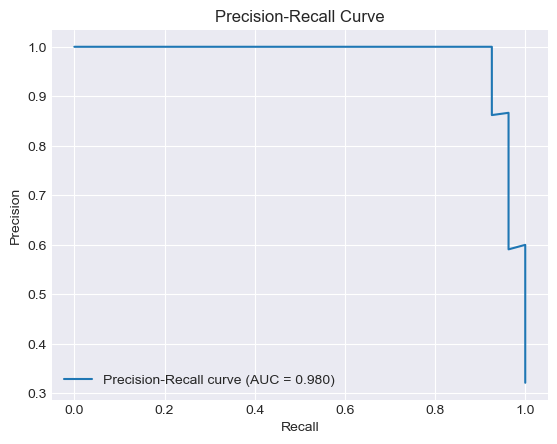

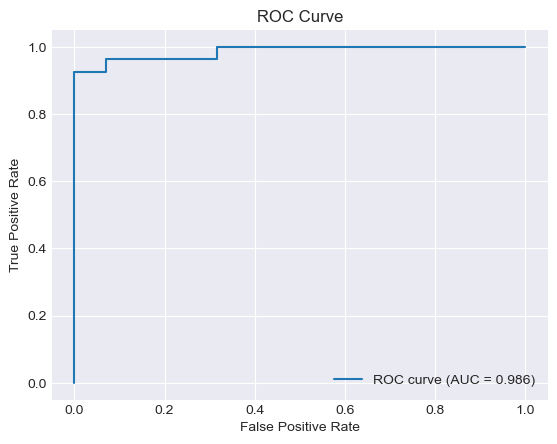

Test AUC-PR: 0.980


In [14]:
random_seed = 42

cv_results = perform_nested_cv(X_train, y_train, random_state=random_seed)  # Perform nested cross-validation
y_test_pred = evaluate_model(cv_results, X_test, y_test)  # Evaluate the model on the test set

# Confusion matrix 

/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_67615/2578609338.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


Text(77.58333333333333, 0.5, 'Actual')

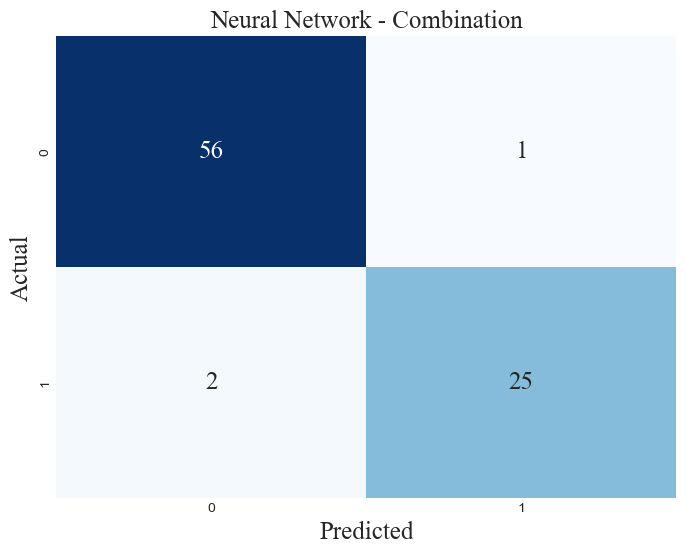

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("Blues", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('Neural Network - Combination', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

# Graph that shows Sum of VVR scores and classification 

In [15]:
pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [33]:
copy_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/X_test_13-06-2024.csv')
display(copy_test)

,Unnamed: 0,Condition,Sum_456,Sum_4567,Sum_1,Sum_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,30,1,26.0,34.0,10.0,9.0,-0.394144,0.113788,0.253906,-0.241433,...,0.435610,0.096632,0.288670,0.368635,-0.626277,-0.010494,0.110803,-0.141865,0.104892,0.106922
1,126,3,34.0,43.0,14.0,12.0,0.825099,-0.190659,-0.069153,0.293698,...,1.666168,0.425279,1.754932,1.737696,0.524330,-0.520376,-0.504625,0.864866,-0.575572,-0.536034
2,199,3,24.0,32.0,9.0,8.0,0.286661,0.569833,0.692545,-0.091596,...,-0.001568,0.425279,0.076727,0.030450,-0.968274,-0.966036,-1.148606,-2.450403,-1.112739,-1.163339
3,142,2,57.0,66.0,17.0,19.0,2.340946,0.853918,0.944420,0.293698,...,2.000224,0.425279,1.243322,1.681337,1.646689,0.774393,0.910237,0.864866,0.405610,0.795791
4,253,3,25.0,33.0,10.0,9.0,-1.091775,-1.363165,-1.790147,-1.750502,...,0.880432,0.425279,0.570028,0.745445,0.147565,0.090425,0.222041,0.864866,-0.205765,0.114488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,92,3,30.0,39.0,10.0,12.0,0.586570,-0.251573,-0.137412,0.293698,...,1.589020,0.425279,1.907163,1.772730,0.511612,-0.405438,-0.356858,0.049067,-0.069567,-0.290302
80,173,3,24.0,32.0,9.0,8.0,1.352037,2.449155,2.157521,0.293698,...,-1.232566,-0.733634,-0.857109,-1.078772,-0.457404,-0.382910,-0.328588,-0.714660,-0.291292,-0.328794
81,55,1,26.0,34.0,10.0,10.0,-0.997972,-0.092138,0.038534,0.293698,...,-1.453697,-1.166064,-1.374354,-1.450532,-0.990030,-0.145579,-0.042962,0.864866,-0.062437,-0.053038
82,251,3,28.0,38.0,12.0,10.0,-0.331540,-0.829194,-0.868273,0.293698,...,-0.839698,-0.543365,-0.677054,-0.783841,-0.145438,-0.223852,-0.134841,-0.315439,-0.185071,-0.154475


In [34]:
display(X_test)

,Condition,Sum_456,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,AU02_r__variance,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,1,26.0,-0.394144,0.113788,0.253906,-0.241433,0.337966,0.277798,-0.874243,-0.569907,...,0.435610,0.096632,0.288670,0.368635,-0.626277,-0.010494,0.110803,-0.141865,0.104892,0.106922
1,3,34.0,0.825099,-0.190659,-0.069153,0.293698,-0.123168,-0.090616,0.406467,-0.315763,...,1.666168,0.425279,1.754932,1.737696,0.524330,-0.520376,-0.504625,0.864866,-0.575572,-0.536034
2,3,24.0,0.286661,0.569833,0.692545,-0.091596,0.683319,0.695538,-0.134549,0.036436,...,-0.001568,0.425279,0.076727,0.030450,-0.968274,-0.966036,-1.148606,-2.450403,-1.112739,-1.163339
3,2,57.0,2.340946,0.853918,0.944420,0.293698,1.052200,0.986488,1.731736,0.006584,...,2.000224,0.425279,1.243322,1.681337,1.646689,0.774393,0.910237,0.864866,0.405610,0.795791
4,3,25.0,-1.091775,-1.363165,-1.790147,-1.750502,-1.504745,-1.738265,-0.185078,-0.531768,...,0.880432,0.425279,0.570028,0.745445,0.147565,0.090425,0.222041,0.864866,-0.205765,0.114488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,3,30.0,0.586570,-0.251573,-0.137412,0.293698,0.077983,-0.080132,0.445783,-0.304901,...,1.589020,0.425279,1.907163,1.772730,0.511612,-0.405438,-0.356858,0.049067,-0.069567,-0.290302
80,3,24.0,1.352037,2.449155,2.157521,0.293698,2.139058,2.180886,1.291554,1.793664,...,-1.232566,-0.733634,-0.857109,-1.078772,-0.457404,-0.382910,-0.328588,-0.714660,-0.291292,-0.328794
81,1,26.0,-0.997972,-0.092138,0.038534,0.293698,-0.262103,-0.050299,-0.832871,-0.036330,...,-1.453697,-1.166064,-1.374354,-1.450532,-0.990030,-0.145579,-0.042962,0.864866,-0.062437,-0.053038
82,3,28.0,-0.331540,-0.829194,-0.868273,0.293698,-0.390558,-0.740947,0.849322,0.834394,...,-0.839698,-0.543365,-0.677054,-0.783841,-0.145438,-0.223852,-0.134841,-0.315439,-0.185071,-0.154475


In [35]:
print(y_test_pred.shape)

(84,)


In [36]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'VVR_scores': copy_test['Sum_4567'],
    'y_test': y_test,
    'y_test_pred': y_test_pred
}
df = pd.DataFrame(data)

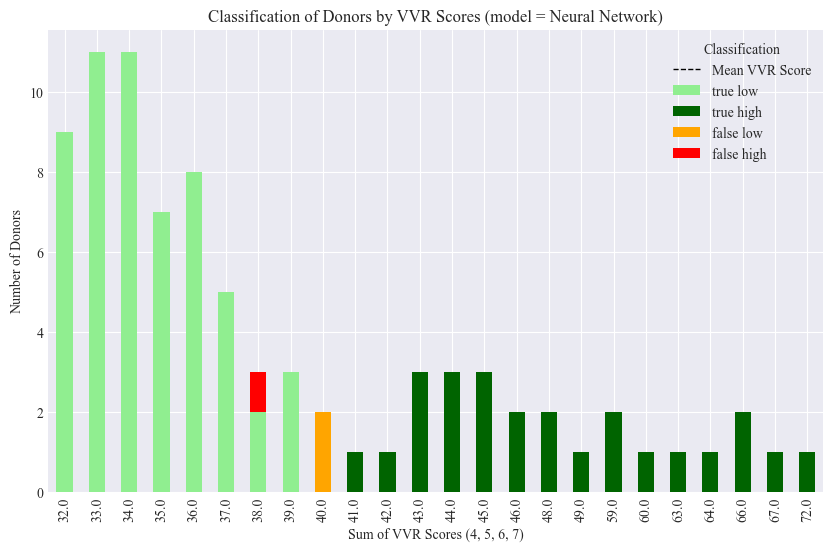

In [38]:
# Add classification labels
df['classification'] = 'false high'
df.loc[(df['y_test'] == 0) & (df['y_test_pred'] == 0), 'classification'] = 'true low'
df.loc[(df['y_test'] == 1) & (df['y_test_pred'] == 1), 'classification'] = 'true high'
df.loc[(df['y_test'] == 0) & (df['y_test_pred'] == 1), 'classification'] = 'false high'
df.loc[(df['y_test'] == 1) & (df['y_test_pred'] == 0), 'classification'] = 'false low'

# Group and count by VVR_score and classification
grouped = df.groupby(['VVR_scores', 'classification']).size().unstack(fill_value=0)

# Reorder columns to ensure "true low" and "true high" are at the bottom of the stack
grouped = grouped[['true low', 'true high', 'false low', 'false high']]

# Colors for the classifications
colors = {
    'true low': 'lightgreen',
    'true high': 'darkgreen',
    'false low': 'orange',
    'false high': 'red'
}

# Set font to Times New Roman
plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman'})

# Plot the stacked bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors.get(x) for x in grouped.columns])

# Add the mean VVR score as a vertical dotted line
mean_vvr_score = 37.62
plt.axvline(x=mean_vvr_score, color='black', linestyle='--', linewidth=1, label='Mean VVR Score')

plt.xlabel('Sum of VVR Scores (4, 5, 6, 7)')
plt.ylabel('Number of Donors')
plt.title('Classification of Donors by VVR Scores (model = Neural Network)')

# Add legend
handles, labels = ax.get_legend_handles_labels()
labels.append('Mean VVR Score')
plt.legend(handles=handles, labels=labels, title='Classification')

plt.show()

# Shap

/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test scores for each fold: [0.96511628 0.96511628 0.89534884]
Fold 1 score: 0.965, SD: 0.033
Fold 2 score: 0.965, SD: 0.033
Fold 3 score: 0.895, SD: 0.033
The mean score using nested cross-validation is: 0.942 ± 0.033
Fold 1 best parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam', 'feature_selection__n_features_to_select': 5}
Fold 2 best parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam', 'feature_selection__n_features_to_select': 5}
Fold 3 best parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam', 'feature_selection__n_features_to_select': 5}

Best model parameters: {'classifier__

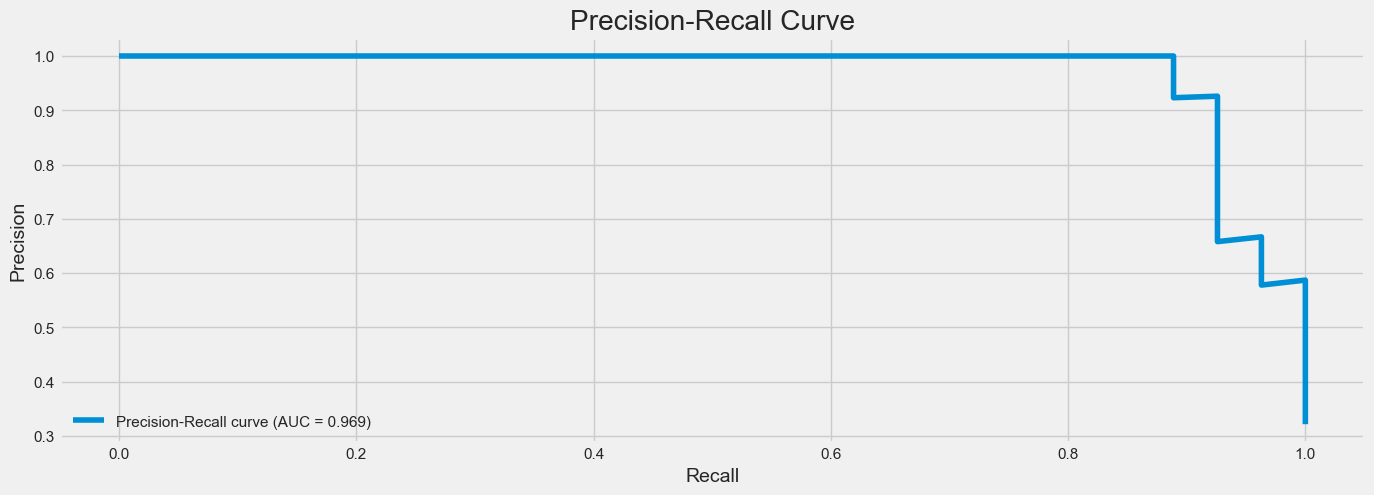

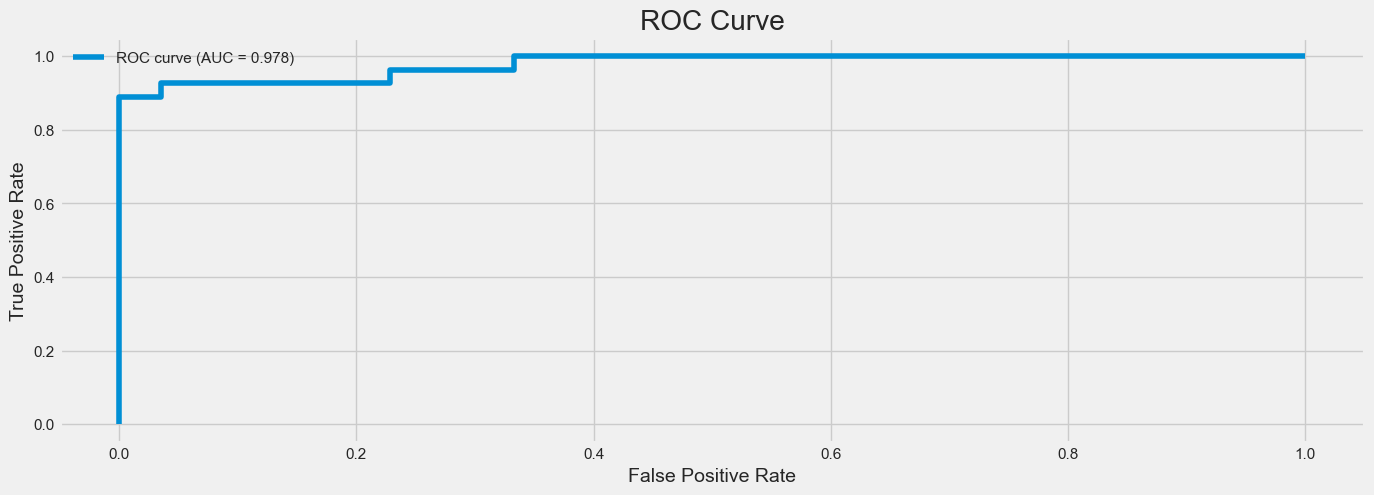

Test AUC-PR: 0.969
Provided model function fails when applied to the provided data set.


ValueError: X has 104 features, but MLPClassifier is expecting 5 features as input.

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
import shap
import matplotlib.pyplot as plt

def build_pipeline():
    """Builds the machine learning pipeline with RFE and RandomForestClassifier."""
    rfe = RFE(estimator=DecisionTreeClassifier(random_state=0))  # Recursive feature elimination with a decision tree
    model = MLPClassifier(random_state=0)  # MLP classifier
    return Pipeline(steps=[('feature_selection', rfe), ('classifier', model)])  # Pipeline combining feature selection and classification

def get_param_grid():
    """Returns the hyperparameter grid for GridSearchCV."""
    return {
        'classifier__hidden_layer_sizes': [(50, 50)],  # Number of neurons in hidden layers
        'classifier__activation': ['tanh'],  # Activation functions
        'classifier__solver': ['adam'],  # Solvers for weight optimization
        'classifier__alpha': [0.001],  # L2 penalty (regularization term) parameter
        'classifier__learning_rate': ['constant'],  # Learning rate schedule
        'feature_selection__n_features_to_select': [5]  # Number of features to select with RFE
    }

def perform_nested_cv(X, y, random_state=0):
    """Performs nested cross-validation and returns the test scores."""
    # Define the inner and outer cross-validation strategies
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
    
    pipeline = build_pipeline()  # Build the pipeline
    param_grid = get_param_grid()  # Get the hyperparameter grid
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2)
    # Perform nested cross-validation
    cv_results = cross_validate(grid_search, X, y, cv=outer_cv, n_jobs=2, return_estimator=True, return_train_score=True)
    
    test_scores = cv_results['test_score']  # Extract test scores
    test_score_mean = test_scores.mean()  # Calculate mean test score
    test_score_std = test_scores.std()  # Calculate standard deviation of test scores
    
    print(f"Test scores for each fold: {test_scores}")
    
    for idx, score in enumerate(test_scores):
        print(f"Fold {idx + 1} score: {score:.3f}, SD: {test_score_std:.3f}")  # Print score and SD for each fold
    
    print(f"The mean score using nested cross-validation is: {test_score_mean:.3f} ± {test_score_std:.3f}")
    
    # Print the best parameters for each fold
    for idx, result in enumerate(cv_results['estimator']):
        print(f"Fold {idx + 1} best parameters: {result.best_params_}")

    # Select the best model based on test scores
    best_fold_index = np.argmax(cv_results['test_score'])
    best_model = cv_results['estimator'][best_fold_index].best_estimator_
    best_params = cv_results['estimator'][best_fold_index].best_params_
    
    print(f"\nBest model parameters: {best_params}")
    
    return cv_results

def plot_curves(y_test, y_proba, y_pred):
    """Plots PR and ROC curves."""
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

def evaluate_model(cv_results, X_test, y_test):
    """Evaluates the model on the test set."""
    best_estimator_per_fold = [result.best_estimator_ for result in cv_results['estimator']]  # Get best estimator for each fold
    
    # Evaluate the best model on the test set
    best_model = best_estimator_per_fold[np.argmax(cv_results['test_score'])]  # Select the best model based on test scores
    
    print("\nEvaluating best model on test set")
    y_test_pred = best_model.predict(X_test)  # Predict on the test set
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))  # Print classification report
    print(confusion_matrix(y_test, y_test_pred))  # Print confusion matrix
    
    y_test_proba = best_model.predict_proba(X_test)[:, 1]  # Get prediction probabilities
    plot_curves(y_test, y_test_proba, y_test_pred)  # Plot PR and ROC curves
    
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    auc_pr = auc(recall, precision)
    print(f"Test AUC-PR: {auc_pr:.3f}")  # Print AUC-PR score
    
    return y_test_pred, best_model

# Add SHAP analysis
def shap_analysis(best_model, X_train, X_test):
    """Performs SHAP analysis on the best model."""
    explainer = shap.KernelExplainer(best_model.named_steps['classifier'].predict, X_train)
    shap_values = explainer.shap_values(X_test)

    # Summarize the effects of all the features
    shap.summary_plot(shap_values, X_test, class_names=["Low VVR group", "High VVR group"])

# Example usage (assuming X_train, y_train, X_test, y_test are already defined):
cv_results = perform_nested_cv(X_train, y_train)
y_test_pred, best_model = evaluate_model(cv_results, X_test, y_test)
shap_analysis(best_model, X_train, X_test)
